





37


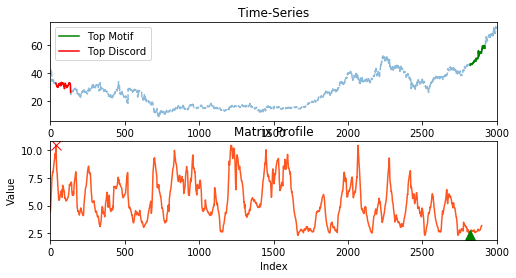

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
data2 =  pd.read_csv('test_data2.csv', sep=',', header=None)



def sliding_dot_product(q, t):
    n = t.size
    m = q.size

    # Append t with n zeros
    ta = np.append(t, np.zeros(n))

    # Reverse Q
    qr = np.flip(q, 0)

    # Append qra
    qra = np.append(qr, np.zeros(2 * n - m))

    # Compute FFTs
    qraf = np.fft.fft(qra)
    taf = np.fft.fft(ta)

    # Compute the inverse FFT to the element-wise multiplication of qraf and taf
    qt = np.fft.ifft(np.multiply(qraf, taf))
    return qt[m:n]


def calculate_distance_profile(q, t, qt, a, sum_q, sum_q2, mean_t, sigma_t):
    n = t.size
    m = q.size

    b = np.zeros(n - m)
    dist = np.zeros(n - m)
    for i in range(0, n - m):
        b[i] = -2 * (qt[i].real - sum_q * mean_t[i]) / sigma_t[i]
        dist[i] = a[i] + b[i] + sum_q2
    return np.sqrt(np.abs(dist))


# The code below takes O(m) for each subsequence
# you should replace it for MASS
def compute_mean_std_for_query(Q):
    # Compute Q stats -- O(n)
    sumQ = np.sum(Q)
    sumQ2 = np.sum(np.power(Q, 2))
    return sumQ, sumQ2


def pre_compute_mean_std_for_TS(ta, m):
    na = len(ta)
    sum_t = np.zeros(na - m)
    sum_t2 = np.zeros(na - m)

    # Compute the stats for t
    cumulative_sum_t = np.cumsum(ta)
    cumulative_sum_t2 = np.cumsum(np.power(ta, 2))
    for i in range(na - m):
        sum_t[i] = cumulative_sum_t[i + m] - cumulative_sum_t[i]
        sum_t2[i] = cumulative_sum_t2[i + m] - cumulative_sum_t2[i]
    mean_t = np.divide(sum_t, m)
    mean_t2 = np.divide(sum_t2, m)
    mean_t_p2 = np.power(mean_t, 2)
    sigma_t2 = np.subtract(mean_t2, mean_t_p2)
    sigma_t = np.sqrt(sigma_t2)
    return sum_t, sum_t2, mean_t, mean_t2, mean_t_p2, sigma_t, sigma_t2


# MUEEN’S ALGORITHM FOR SIMILARITY SEARCH (MASS)
def mass(Q, T, a, meanT, sigmaT):
    # Z-Normalisation
    if np.std(Q) != 0:
        Q = (Q - np.mean(Q)) / np.std(Q)
    QT = sliding_dot_product(Q, T)
    sumQ, sumQ2 = compute_mean_std_for_query(Q)
    return calculate_distance_profile(Q, T, QT, a, sumQ, sumQ2, meanT, sigmaT)


def element_wise_min(Pab, Iab, D, idx, ignore_trivial, m):
    for i in range(0, len(D)):
        if not ignore_trivial or (np.abs(idx - i) > m/2.0): # if it's a self-join, ignore trivial matches in [-m/2,m/2]
            if D[i] < Pab[i]:
                Pab[i] = D[i]
                Iab[i] = idx
    return Pab, Iab


def stamp(Ta, Tb, m):
    """
    Compute the Matrix Profile between time-series Ta and Tb.
    If Ta==Tb, the operation is a self-join and trivial matches are ignored.
    
    :param Ta: time-series, np.array
    :param Tb: time-series, np.array
    :param m: subsequence length
    :return: Matrix Profile, Nearest-Neighbor indexes
    """
    nb = len(Tb)
    na = len(Ta)
    Pab = np.ones(na - m)* np.inf
    Iab = np.zeros(na - m)
    idxes = np.arange(nb - m + 1)

    sumT, sumT2, meanT, meanT_2, meanTP2, sigmaT, sigmaT2 = pre_compute_mean_std_for_TS(Ta, m)

    a = np.zeros(na - m)
    for i in range(0, na - m):
        a[i] = (sumT2[i] - 2 * sumT[i] * meanT[i] + m * meanTP2[i]) / sigmaT2[i]

    for idx in idxes:
        D = mass(Tb[idx: idx + m], Ta, a, meanT, sigmaT)
        Pab, Iab = element_wise_min(Pab, Iab, D, idx, ignore_trivial = np.atleast_1d(Ta == Tb).all(), m=m)

    return Pab, Iab


# Quick Test
def test_stamp(Ta, Tb, m):
    start_time = time.time()

    Pab, Iab = stamp(Ta, Tb, m)
    print("--- %s seconds ---" % (time.time() - start_time))

    plot_discord(Ta, Tb, Pab, Iab, m, )
    return Pab, Iab


def plot_discord(Ta, Tb, values, indexes, m):
    from matplotlib import gridspec
    plt.figure(figsize=(8,4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[int(len(Ta)/len(Tb)), 1]) 

    plt.subplot(gs[0])
    plt.plot(Ta, linestyle='--')
    plt.xlim((0, len(Ta)))
        
    plt.plot(range(np.argmin(values), np.argmin(values) + m), Ta[np.argmin(values):np.argmin(values) + m], c='g', label='Best Match')
    plt.legend(loc='best')
    plt.title('Time-Series')
    plt.ylim((-3,3))

    plt.subplot(gs[1])
    plt.plot(Tb)
    

    plt.title('Query')
    plt.xlim((0, len(Tb)))
    plt.ylim((-3,3))

    plt.figure()
    plt.title('Matrix Profile')
    plt.plot(range(0, len(values)), values, '#ff5722')
    plt.plot(np.argmax(values), np.max(values), marker='x', c='r', ms=10)
    plt.plot(np.argmin(values), np.min(values), marker='^', c='g', ms=10)

    plt.xlim((0, len(Ta)))
    plt.xlabel('Index')
    plt.ylabel('Value')


    plt.show()




def plot_motif(Ta, Tb, values, indexes, m):
    from matplotlib import gridspec
    plt.figure(figsize=(8,4))
    plt.subplot(211)
    plt.plot(Ta, linestyle='--', alpha=0.5)
    plt.xlim((0, len(Ta)))
    
    print(np.argmax(values))
    
    plt.plot(range(np.argmin(values), np.argmin(values) + m), Ta[np.argmin(values):np.argmin(values) + m], c='g', label='Top Motif')
    plt.plot(range(np.argmax(values), np.argmax(values) + m), Ta[np.argmax(values):np.argmax(values) + m], c='r', label='Top Discord')
    
    plt.legend(loc='best')
    plt.title('Time-Series')


    plt.subplot(212)
    plt.title('Matrix Profile')
    plt.plot(range(0, len(values)), values, '#ff5722')
    plt.plot(np.argmax(values), np.max(values), marker='x', c='r', ms=10)
    plt.plot(np.argmin(values), np.min(values), marker='^', c='g', ms=10)

    plt.xlim((0, len(Ta)))
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()
    print('\n')
    print('\n')
    print('\n')

#print(data.head())

ts = data2.iloc[1:,1].values.flatten()  # pick a random sample from class 0
ts = ts.astype(np.float)
#from owlpy.core import *

Pab, Iab = stamp(ts,ts,100)                       # run the STAMP algorithm to compute the Matrix Profile
print('\n')
print('\n')
print('\n')
plot_motif(ts,ts,Pab,Iab,100)




